In [94]:
from numpy import *
from numpy import random
from numba import jit
import matplotlib.pyplot as plt


#### Randomize lattice and calculate energy
$H = -\sum_{<r, r'>} S_r S_{r'}$

In [95]:
@jit(nopython=True)
def CEnergy(latt):
    N = shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]  
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.

def RandomL(N):
    return array(sign(2*random.random((N,N))-1),dtype=int) 

#### Energy range $[-2N^2, -2N^2 + 4, ..., 2N^2]$

In [96]:
def PrepareEnergies(N):
    Energies = (array(4*arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist()
    Energies.pop(1)  
    Energies.pop(-2) 
    Energies = array(Energies) 
    Emin, Emax = Energies[0],Energies[-1]
    
    indE = -ones(Emax+1-Emin, dtype=int)
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    return (Energies, indE, Emin)

#### Wang Landau

In [97]:
from numpy import random
def WangLandau(Nitt, N, flatness):
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)
    (lngE, Hist) = RunWangLandau(Nitt,Energies,latt,indE)
    return (Energies,lngE, Hist)

@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = zeros(len(Energies))
    # Histogram
    Hist = zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) 
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]] # log(g(Enew))
        lgold = lngE[indE[Ene-Emin]]  # log(g(Eold))
        P = 1.0
        if lgold-lgnew < 0 : P=exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf   # g(E) -> g(E)*f hence log(g(E)) -> log(g(E))+log(f)
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', exp(lnf))
    return (lngE, Hist)

In [107]:
from numpy import random

flatness = 0.92
N = 4
Nitt = int(10e8)

(Energies, lngE, Hist) = WangLandau(Nitt, N, flatness)
print('Done')

4999 histogram is flat 309.0 312.5 f= 1.6487212707001282
7999 histogram is flat 179.0 187.5 f= 1.2840254166877414
12999 histogram is flat 299.0 312.5 f= 1.1331484530668263
19999 histogram is flat 399.0 437.5 f= 1.0644944589178593
23999 histogram is flat 231.0 250.0 f= 1.0317434074991028
28999 histogram is flat 287.0 312.5 f= 1.0157477085866857
35999 histogram is flat 433.0 437.5 f= 1.007843097206448
45999 histogram is flat 573.0 625.0 f= 1.0039138893383475
57999 histogram is flat 693.0 750.0 f= 1.0019550335910028
62999 histogram is flat 289.0 312.5 f= 1.0009770394924165
104999 histogram is flat 2556.0 2625.0 f= 1.0004884004786945
134999 histogram is flat 1718.0 1875.0 f= 1.0002441704297478
147999 histogram is flat 768.0 812.5 f= 1.0001220777633837
170999 histogram is flat 1343.0 1437.5 f= 1.0000610370189331
199999 histogram is flat 1669.0 1812.5 f= 1.000030518043791
222999 histogram is flat 1318.0 1437.5 f= 1.0000152589054785
250999 histogram is flat 1594.0 1750.0 f= 1.000007629423635


In [108]:
lngE[0],lngE[-1]

(np.float64(617.4336755551699), np.float64(617.2640183139074))

In [109]:
# Proper normalization of the Density of states
# g *= 4/(g[0]+g[-1]) = 4/(g[-1]*(1+g[0]/g[-1]))
# g = g * 4/(g[-1]*(1+g[0]/g[-1]))
# log(g) = log(g) + log(4)-log(g[-1]) - log(1+g[0]/g[-1])
# log(g) += log(4)-log(g[-1])-log(1+exp(log(g[0])-log(g[-1])))
# 
if lngE[-1]>lngE[0]:
    lgC = log(4)-lngE[-1]-log(1+exp(lngE[0]-lngE[-1]))
else:
    lgC = log(4)-lngE[0]-log(1+exp(lngE[-1]-lngE[0]))

lngE += lgC

In [110]:
exp(lngE[0])+exp(lngE[-1]), exp(lngE[0]), exp(lngE[-1])  # g[0]+g[-1]

(np.float64(4.000000000000155),
 np.float64(2.169251463970372),
 np.float64(1.8307485360297837))

[-32 -24 -20 -16 -12  -8  -4   0   4   8  12  16  20  24  32]


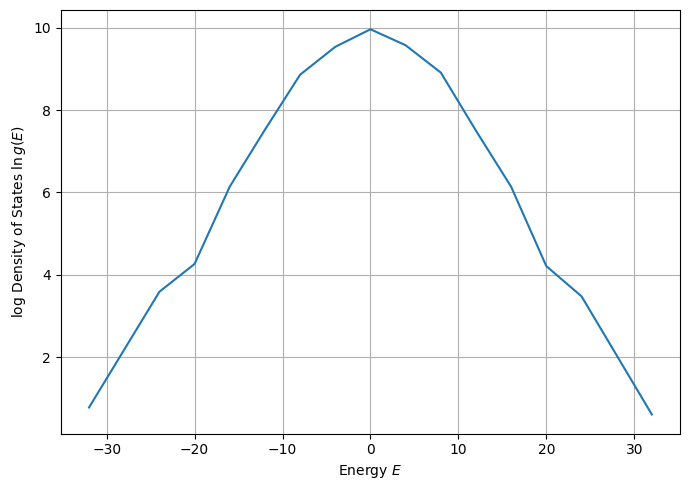

In [111]:
print(Energies)
plt.figure(figsize=(7,5))
plt.plot(Energies, lngE)
plt.xlabel("Energy $E$")
plt.ylabel("log Density of States $\\ln g(E)$")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Parition function:
$Z = \sum_{E} g[E] e^{-E/T}$

In [112]:
print(len(Energies), len(lngE))

15 15


In [113]:
import numpy as np
def partition_function(Energies, lngE, T):
    """
    Compute partition function Z(T) from Wang-Landau output.
    Args:
        Energies: array of energy values
        lngE: array of ln(g(E)) values
        T: temperature or array of temperatures
    Returns:
        Z: partition function(s) at given temperature(s)
    """
    Energies = np.array(Energies)
    lngE = np.array(lngE)
    if np.isscalar(T):
        Z = np.sum(np.exp(lngE - Energies / T))
        return Z
    else:
        Zs = []
        for temp in T:
            Zs.append(np.sum(np.exp(lngE - Energies / temp)))
        return np.array(Zs)

Tc = 2.269
delta = 1.5

Te = np.linspace(Tc - delta, Tc + delta, 5)
Z = []
for T in Te:
    Z.append(partition_function(Energies, lngE,T))
Z = array(Z)

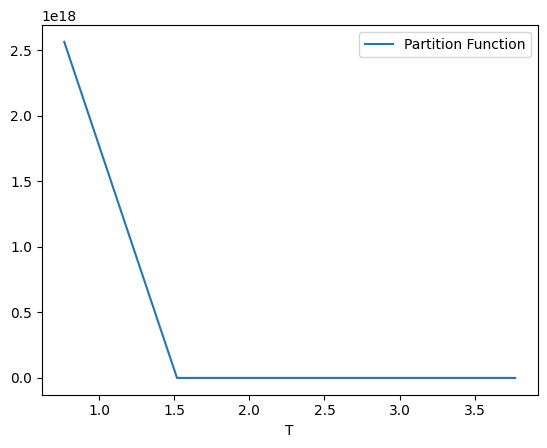

In [114]:
plt.plot(Te, Z, label='Partition Function')
plt.xlabel('T')
plt.legend(loc='best')
plt.show()

In [115]:
print(Z)

[2.56214344e+18 3.38098329e+09 6.03130588e+06 6.11622789e+05
 2.49008562e+05]


In [64]:
import numpy as np
import math
import random as r
from numba import jit
import itertools
import matplotlib.pyplot as plt

k_B = 1  # Boltzmann constant

def enumerate_partition_function(N, T):
    """
    Brute force enumeration to compute Z(T).
    """
    n_sites = N*N
    Z = 0.0
    for spins in itertools.product([-1, 1], repeat=n_sites):
        # Convert spins tuple to N x N lattice
        latt = np.array(spins).reshape((N, N))
        E = CEnergy(latt, N)
        Z += math.exp(-E / (k_B * T))
    return Z



sign = lambda x : math.copysign(1, x)

@jit(nopython=True)
def CEnergy(latt, N):
    Ene = 0
    for i in range(N):
        for j in range(N):
            S = latt[i,j]
            WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
            Ene += -S*WF
    return int(Ene/2)

def RandomL(N):
    latt = np.zeros((N,N), dtype=int)
    for i in range(N):
        for j in range(N):
            latt[i,j] = sign(2*r.random() - 1)
    return latt


N = 4  
Te = np.linspace(Tc - delta, Tc + delta, 5)
Z_exact = []
print(f"Enumerating all {2**(N*N):,} configurations for N={N} ...")
for T in Te:
    Z_exact.append(enumerate_partition_function(N, T))
Z_exact = np.array(Z_exact)
print(Z_exact)

Enumerating all 65,536 configurations for N=4 ...
[2.36219219e+18 3.10728353e+09 5.51408947e+06 5.66417185e+05
 2.33754580e+05]


Squared errors: [7.22323781e+32 2.84182742e+14 1.26873674e+09 8.49322433e+06
 1.54242414e+07]


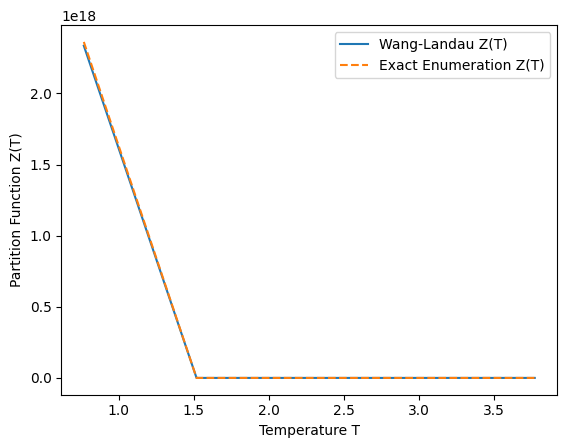

In [66]:
squared_errors = (Z - Z_exact) ** 2
print("Squared errors:", squared_errors)
plt.plot(Te, Z, label='Wang-Landau Z(T)')
plt.plot(Te, Z_exact, label='Exact Enumeration Z(T)', linestyle='--')
plt.xlabel('Temperature T')
plt.ylabel('Partition Function Z(T)')
plt.legend(loc='best')
plt.show()